In [32]:
import pandas as pd
from dp_transformer import DifferentialPrivacyTransformer
import numpy as np
import pandas as pd
from dp_mechanisms.quantitative import (
    duchi_mechanism,
    piecewise_mechanism,
    normalize_to_range,
    denormalize_from_range,
    laplace_mechanism,
    multidimensional_mechanism
)
from dp_mechanisms.categorical import direct_encoding, optimized_unary_encoding, rappor
from dp_plotting import plot_mean_vs_privatized, plot_histograms
import torch

In [31]:
#david path: C:\Users\David\Universidad de los andes\David Stiven Romero Grajales - Trabajo de Grado\Trabajo de Grado 1\Base de datos y descripción\Titanic
#Allan path:´../Titanic/bases/titanic_data_clean.csv´

titanic_data = pd.read_csv('C:/Users/David/Universidad de los andes/David Stiven Romero Grajales - Trabajo de Grado/Trabajo de Grado 1/Base de datos y descripción/Titanic/train.csv')


In [33]:
def multiple_classifiers(titanic_data, n_splits=10):
    """
    Evaluates multiple classifiers on the Titanic dataset with cross-validation.

    Parameters:
    - titanic_data (pd.DataFrame): The Titanic dataset with necessary columns.
    - n_splits (int): Number of folds for cross-validation.

    Returns:
    - metrics_df (pd.DataFrame): DataFrame containing average metrics for each model.
    """
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.preprocessing import LabelEncoder
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.naive_bayes import GaussianNB
    from catboost import CatBoostClassifier

    # Identify numerical and categorical columns
    numerical_columns = ['SibSp', 'Parch', 'Fare']
    categorical_columns = ['Pclass', 'Sex', 'Embarked']

    # Handle missing values
    titanic_data = titanic_data.copy()
    for col in numerical_columns:
        titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)

    for col in categorical_columns:
        titanic_data[col].fillna(titanic_data[col].mode()[0], inplace=True)

    # Encode categorical variables to numerical format
    for col in categorical_columns:
        le = LabelEncoder()
        titanic_data[col] = le.fit_transform(titanic_data[col].astype(str))

    # Separate features and target variable
    Y = titanic_data['Survived'].values
    X = titanic_data.drop('Survived', axis=1)

    # Ensure all features are numeric
    X = X.apply(pd.to_numeric, errors='coerce')

    # Handle any NaN or infinite values
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    if X.isnull().values.any():
        X.fillna(0, inplace=True)  # Replace NaNs with zero or another appropriate value

    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(solver='liblinear'),
        'Random Forest': RandomForestClassifier(random_state=0),
        'GaussianNB': GaussianNB(),
        'CatBoost': CatBoostClassifier(verbose=0, random_state=0)
    }

    # Metrics to collect
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']

    # Dictionary to store metrics for each model
    model_metrics = {model_name: {metric: [] for metric in metrics} for model_name in models.keys()}

    # Perform cross-validation for each model
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        for model_name, model in models.items():
            # Fit the model
            model.fit(X_train, Y_train)
            Y_pred = model.predict(X_test)

            # Compute metrics
            accuracy = accuracy_score(Y_test, Y_pred)
            precision = precision_score(Y_test, Y_pred, zero_division=0)
            recall = recall_score(Y_test, Y_pred, zero_division=0)
            f1 = f1_score(Y_test, Y_pred, zero_division=0)

            # Store metrics
            model_metrics[model_name]['accuracy'].append(accuracy)
            model_metrics[model_name]['precision'].append(precision)
            model_metrics[model_name]['recall'].append(recall)
            model_metrics[model_name]['f1_score'].append(f1)

    # Calculate average metrics
    metrics_list = []
    for model_name, metric_values in model_metrics.items():
        avg_accuracy = np.mean(metric_values['accuracy'])
        avg_precision = np.mean(metric_values['precision'])
        avg_recall = np.mean(metric_values['recall'])
        avg_f1_score = np.mean(metric_values['f1_score'])
        metrics_list.append({
            'Model': model_name,
            'Accuracy': avg_accuracy,
            'Precision': avg_precision,
            'Recall': avg_recall,
            'F1 Score': avg_f1_score
        })
        print(f"\nMetrics for {model_name} over {n_splits} folds:")
        print(f"Accuracy: {avg_accuracy * 100:.2f}%")
        print(f"Precision: {avg_precision * 100:.2f}%")
        print(f"Recall: {avg_recall * 100:.2f}%")
        print(f"F1 Score: {avg_f1_score * 100:.2f}%")

    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    return metrics_df


C:\Users\David\AppData\Local\Temp\ipykernel_5300\1627873268.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\1627873268.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression over 10 folds:
Accuracy: 65.65%
Precision: 61.80%
Recall: 29.50%
F1 Score: 39.34%

Metrics for Random Forest over 10 folds:
Accuracy: 83.28%
Precision: 83.10%
Recall: 71.34%
F1 Score: 76.55%

Metrics for GaussianNB over 10 folds:
Accuracy: 66.89%
Precision: 70.02%
Recall: 23.38%
F1 Score: 34.66%

Metrics for CatBoost over 10 folds:
Accuracy: 83.05%
Precision: 82.53%
Recall: 71.36%
F1 Score: 76.39%


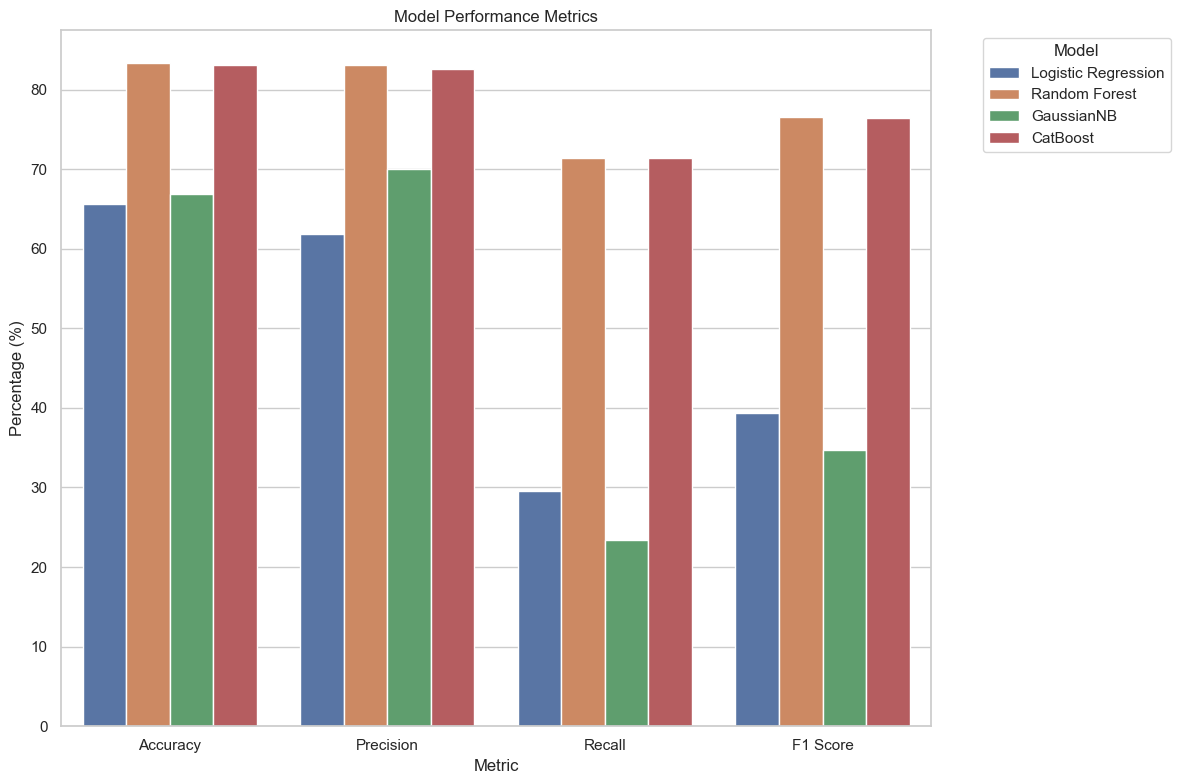

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_metrics(metrics_df):
    """
    Plots the performance metrics of different models.

    Parameters:
    - metrics_df (pd.DataFrame): DataFrame containing average metrics for each model.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Set the style for seaborn
    sns.set(style="whitegrid")

    # Melt the DataFrame to long format for easier plotting
    metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

    # Convert metric values to percentages
    metrics_melted['Value'] = metrics_melted['Value'] * 100

    # Create a figure and axis
    plt.figure(figsize=(12, 8))

    # Create a barplot
    sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_melted)

    # Set plot title and labels
    plt.title('Model Performance Metrics')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Metric')

    # Adjust legend
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have the Titanic dataset loaded as 'titanic_data'
metrics_df = multiple_classifiers(titanic_data)
plot_model_metrics(metrics_df)


In [35]:
metrics_df = multiple_classifiers(titanic_data)

#metrics DataFrame
print(metrics_df)


C:\Users\David\AppData\Local\Temp\ipykernel_5300\1627873268.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\1627873268.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression over 10 folds:
Accuracy: 65.65%
Precision: 61.80%
Recall: 29.50%
F1 Score: 39.34%

Metrics for Random Forest over 10 folds:
Accuracy: 83.28%
Precision: 83.10%
Recall: 71.34%
F1 Score: 76.55%

Metrics for GaussianNB over 10 folds:
Accuracy: 66.89%
Precision: 70.02%
Recall: 23.38%
F1 Score: 34.66%

Metrics for CatBoost over 10 folds:
Accuracy: 83.05%
Precision: 82.53%
Recall: 71.36%
F1 Score: 76.39%
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.656517   0.618030  0.294958  0.393440
1        Random Forest  0.832759   0.830987  0.713445  0.765461
2           GaussianNB  0.668914   0.700210  0.233782  0.346626
3             CatBoost  0.830549   0.825262  0.713613  0.763858


In [36]:
def dp_multiple_classifiers(titanic_data, epsilon_numerical, epsilon_categorical, num_method, cat_method, n_splits=10):
    """
    Applies differential privacy to the Titanic dataset using specified methods and evaluates multiple classifiers.

    Parameters:
    - titanic_data (pd.DataFrame): The Titanic dataset with necessary columns.
    - epsilon_numerical (float): Privacy parameter for numerical variables.
    - epsilon_categorical (float): Privacy parameter for categorical variables.
    - num_method (str): Method to apply for numerical variables ('duchi', 'piecewise', 'laplace').
    - cat_method (str): Method to apply for categorical variables ('direct_encoding', 'optimized_unary_encoding', 'rappor').
    - n_splits (int): Number of folds for cross-validation.

    Returns:
    - metrics_df (pd.DataFrame): DataFrame containing average metrics for each model.
    """
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.preprocessing import LabelEncoder
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.naive_bayes import GaussianNB
    from catboost import CatBoostClassifier
    from dp_transformer import DifferentialPrivacyTransformer  # Import the DP transformer

    # Identify numerical and categorical columns
    numerical_columns = ['SibSp', 'Parch', 'Fare']
    categorical_columns = ['Pclass', 'Sex', 'Embarked']

    # Handle missing values
    titanic_data = titanic_data.copy()
    for col in numerical_columns:
        titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)

    for col in categorical_columns:
        titanic_data[col].fillna(titanic_data[col].mode()[0], inplace=True)

    # Initialize the DifferentialPrivacyTransformer
    dpt = DifferentialPrivacyTransformer(
        df=titanic_data,
        epsilon_quantitative=epsilon_numerical,
        epsilon_categorical=epsilon_categorical,
        quantitative_vars=numerical_columns,
        categorical_vars=categorical_columns
    )

    # Apply differential privacy to numerical variables
    dpt.fit_quantitative(method=num_method)

    # Apply differential privacy to categorical variables
    dpt.fit_categorical(method=cat_method)

    # Encode categorical variables to numerical format
    for col in categorical_columns:
        le = LabelEncoder()
        dpt.df_transformed[col] = le.fit_transform(dpt.df_transformed[col].astype(str))

    # Separate features and target variable
    Y = titanic_data['Survived'].values
    X = dpt.df_transformed.drop('Survived', axis=1)

    # Ensure all features are numeric
    X = X.apply(pd.to_numeric, errors='coerce')

    # Handle any NaN or infinite values
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    if X.isnull().values.any():
        X.fillna(0, inplace=True)  # Replace NaNs with zero or another appropriate value

    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(solver='liblinear'),
        'Random Forest': RandomForestClassifier(random_state=0),
        'GaussianNB': GaussianNB(),
        'CatBoost': CatBoostClassifier(verbose=0, random_state=0)
    }

    # Metrics to collect
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']

    # Dictionary to store metrics for each model
    model_metrics = {model_name: {metric: [] for metric in metrics} for model_name in models.keys()}

    # Perform cross-validation for each model
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        for model_name, model in models.items():
            # Fit the model
            model.fit(X_train, Y_train)
            Y_pred = model.predict(X_test)

            # Compute metrics
            accuracy = accuracy_score(Y_test, Y_pred)
            precision = precision_score(Y_test, Y_pred, zero_division=0)
            recall = recall_score(Y_test, Y_pred, zero_division=0)
            f1 = f1_score(Y_test, Y_pred, zero_division=0)

            # Store metrics
            model_metrics[model_name]['accuracy'].append(accuracy)
            model_metrics[model_name]['precision'].append(precision)
            model_metrics[model_name]['recall'].append(recall)
            model_metrics[model_name]['f1_score'].append(f1)

    # Calculate average metrics
    metrics_list = []
    for model_name, metric_values in model_metrics.items():
        avg_accuracy = np.mean(metric_values['accuracy'])
        avg_precision = np.mean(metric_values['precision'])
        avg_recall = np.mean(metric_values['recall'])
        avg_f1_score = np.mean(metric_values['f1_score'])
        metrics_list.append({
            'Model': model_name,
            'Accuracy': avg_accuracy,
            'Precision': avg_precision,
            'Recall': avg_recall,
            'F1 Score': avg_f1_score
        })
        print(f"\nMetrics for {model_name} with ε_numerical={epsilon_numerical}, ε_categorical={epsilon_categorical}, num_method={num_method}, cat_method={cat_method} over {n_splits} folds:")
        print(f"Accuracy: {avg_accuracy * 100:.2f}%")
        print(f"Precision: {avg_precision * 100:.2f}%")
        print(f"Recall: {avg_recall * 100:.2f}%")
        print(f"F1 Score: {avg_f1_score * 100:.2f}%")

    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    return metrics_df


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product


# Define epsilon values
epsilon_values = np.logspace(-2, 2, 5)  # [0.01, 0.1, 1, 10, 100]

# Define methods to try
numerical_methods = ['duchi', 'piecewise', 'laplace']
categorical_methods = ['direct_encoding', 'oue', 'rappor']

# Create a directory to save the plots
import os
if not os.path.exists('plots'):
    os.makedirs('plots')

# List of colors for the models
model_colors = {
    'Logistic Regression': 'red',
    'Random Forest': 'blue',
    'GaussianNB': 'green',
    'CatBoost': 'purple'
}

# Loop over all combinations of numerical and categorical methods
for num_method, cat_method in product(numerical_methods, categorical_methods):
    print(f"\nEvaluating combination: Numerical Method = {num_method}, Categorical Method = {cat_method}")
    results = {}

    for epsilon in epsilon_values:
        print(f"Testing with ε_numerical = ε_categorical = {epsilon}")
        try:
            metrics_df = dp_multiple_classifiers(
                titanic_data.copy(),
                epsilon_numerical=epsilon,
                epsilon_categorical=epsilon,
                num_method=num_method,
                cat_method=cat_method,
                n_splits=10
            )
            # Store metrics for each model
            for index, row in metrics_df.iterrows():
                model_name = row['Model']
                if model_name not in results:
                    results[model_name] = {'epsilon': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
                results[model_name]['epsilon'].append(epsilon)
                results[model_name]['accuracy'].append(row['Accuracy'])
                results[model_name]['precision'].append(row['Precision'])
                results[model_name]['recall'].append(row['Recall'])
                results[model_name]['f1_score'].append(row['F1 Score'])
        except Exception as e:
            print(f"An error occurred: {e}")
            continue

    # Plot Accuracy vs. Epsilon for each model with specified colors
    plt.figure(figsize=(10, 6))

    for model_name, data in results.items():
        color = model_colors.get(model_name, None)  # Get the color for the model
        plt.plot(
            data['epsilon'],
            [acc * 100 for acc in data['accuracy']],
            marker='o',
            label=model_name,
            color=color
        )

    plt.xscale('log')
    plt.xlabel('Epsilon (ε)')
    plt.ylabel('Average Accuracy (%)')
    plt.title(f'Model Accuracy vs. Epsilon\nNumerical Method: {num_method}, Categorical Method: {cat_method}')
    plt.grid(True, which='both', ls='--')
    plt.legend()
    plt.tight_layout()
    # Save the plot
    filename = f'plots/accuracy_vs_epsilon_{num_method}_{cat_method}.png'
    plt.savefig(filename)
    plt.close()
    print(f"Plot saved as {filename}")



Evaluating combination: Numerical Method = duchi, Categorical Method = direct_encoding
Testing with ε_numerical = ε_categorical = 0.01


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.01, ε_categorical=0.01, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 60.38%
Precision: 38.62%
Recall: 5.56%
F1 Score: 9.62%

Metrics for Random Forest with ε_numerical=0.01, ε_categorical=0.01, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 62.18%
Precision: 50.99%
Recall: 34.82%
F1 Score: 41.05%

Metrics for GaussianNB with ε_numerical=0.01, ε_categorical=0.01, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 59.59%
Precision: 30.67%
Recall: 10.58%
F1 Score: 13.32%

Metrics for CatBoost with ε_numerical=0.01, ε_categorical=0.01, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 63.64%
Precision: 54.25%
Recall: 40.08%
F1 Score: 45.58%
Testing with ε_numerical = ε_categorical = 0.1


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.1, ε_categorical=0.1, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 60.94%
Precision: 40.00%
Recall: 3.78%
F1 Score: 6.78%

Metrics for Random Forest with ε_numerical=0.1, ε_categorical=0.1, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 63.65%
Precision: 54.03%
Recall: 33.92%
F1 Score: 41.23%

Metrics for GaussianNB with ε_numerical=0.1, ε_categorical=0.1, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 59.59%
Precision: 34.29%
Recall: 13.79%
F1 Score: 18.52%

Metrics for CatBoost with ε_numerical=0.1, ε_categorical=0.1, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 63.42%
Precision: 53.66%
Recall: 35.70%
F1 Score: 42.29%
Testing with ε_numerical = ε_categorical = 1.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=1.0, ε_categorical=1.0, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 61.17%
Precision: 35.50%
Recall: 3.76%
F1 Score: 6.57%

Metrics for Random Forest with ε_numerical=1.0, ε_categorical=1.0, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 66.00%
Precision: 58.98%
Recall: 39.19%
F1 Score: 46.72%

Metrics for GaussianNB with ε_numerical=1.0, ε_categorical=1.0, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 59.26%
Precision: 21.37%
Recall: 8.79%
F1 Score: 12.09%

Metrics for CatBoost with ε_numerical=1.0, ε_categorical=1.0, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 67.23%
Precision: 60.31%
Recall: 42.69%
F1 Score: 49.51%
Testing with ε_numerical = ε_categorical = 10.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=10.0, ε_categorical=10.0, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 62.85%
Precision: 55.33%
Recall: 9.93%
F1 Score: 16.72%

Metrics for Random Forest with ε_numerical=10.0, ε_categorical=10.0, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 80.14%
Precision: 79.36%
Recall: 66.08%
F1 Score: 71.71%

Metrics for GaussianNB with ε_numerical=10.0, ε_categorical=10.0, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 62.85%
Precision: 53.47%
Recall: 10.52%
F1 Score: 17.53%

Metrics for CatBoost with ε_numerical=10.0, ε_categorical=10.0, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 81.93%
Precision: 83.86%
Recall: 66.08%
F1 Score: 73.54%
Testing with ε_numerical = ε_categorical = 100.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=100.0, ε_categorical=100.0, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 62.74%
Precision: 57.23%
Recall: 8.48%
F1 Score: 14.47%

Metrics for Random Forest with ε_numerical=100.0, ε_categorical=100.0, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 81.03%
Precision: 80.03%
Recall: 68.12%
F1 Score: 73.15%

Metrics for GaussianNB with ε_numerical=100.0, ε_categorical=100.0, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 62.29%
Precision: 50.55%
Recall: 8.48%
F1 Score: 14.30%

Metrics for CatBoost with ε_numerical=100.0, ε_categorical=100.0, num_method=duchi, cat_method=direct_encoding over 10 folds:
Accuracy: 82.38%
Precision: 83.55%
Recall: 67.55%
F1 Score: 74.47%
Plot saved as plots/accuracy_vs_epsilon_duchi_direct_encoding.png

Evaluating combination: Numerical Method = duchi, Categorical Method = oue
Testing with ε_numerical = ε_categorical = 0.01


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.01, ε_categorical=0.01, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 60.27%
Precision: 39.38%
Recall: 5.55%
F1 Score: 9.58%

Metrics for Random Forest with ε_numerical=0.01, ε_categorical=0.01, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 62.74%
Precision: 52.89%
Recall: 38.31%
F1 Score: 44.12%

Metrics for GaussianNB with ε_numerical=0.01, ε_categorical=0.01, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 58.36%
Precision: 27.06%
Recall: 14.40%
F1 Score: 17.60%

Metrics for CatBoost with ε_numerical=0.01, ε_categorical=0.01, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 64.76%
Precision: 56.01%
Recall: 41.27%
F1 Score: 46.95%
Testing with ε_numerical = ε_categorical = 0.1


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.1, ε_categorical=0.1, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 60.61%
Precision: 23.33%
Recall: 2.04%
F1 Score: 3.70%

Metrics for Random Forest with ε_numerical=0.1, ε_categorical=0.1, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 61.84%
Precision: 50.12%
Recall: 34.50%
F1 Score: 40.39%

Metrics for GaussianNB with ε_numerical=0.1, ε_categorical=0.1, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 60.83%
Precision: 25.46%
Recall: 13.24%
F1 Score: 16.55%

Metrics for CatBoost with ε_numerical=0.1, ε_categorical=0.1, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 63.98%
Precision: 53.77%
Recall: 38.92%
F1 Score: 44.86%
Testing with ε_numerical = ε_categorical = 1.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=1.0, ε_categorical=1.0, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 61.73%
Precision: 40.00%
Recall: 1.46%
F1 Score: 2.81%

Metrics for Random Forest with ε_numerical=1.0, ε_categorical=1.0, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 65.21%
Precision: 57.37%
Recall: 39.16%
F1 Score: 46.29%

Metrics for GaussianNB with ε_numerical=1.0, ε_categorical=1.0, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 60.49%
Precision: 27.09%
Recall: 9.12%
F1 Score: 12.20%

Metrics for CatBoost with ε_numerical=1.0, ε_categorical=1.0, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 67.23%
Precision: 60.63%
Recall: 44.14%
F1 Score: 50.65%
Testing with ε_numerical = ε_categorical = 10.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=10.0, ε_categorical=10.0, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 61.95%
Precision: 58.35%
Recall: 8.80%
F1 Score: 14.96%

Metrics for Random Forest with ε_numerical=10.0, ε_categorical=10.0, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 67.46%
Precision: 60.25%
Recall: 45.06%
F1 Score: 51.22%

Metrics for GaussianNB with ε_numerical=10.0, ε_categorical=10.0, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 62.40%
Precision: 62.19%
Recall: 9.95%
F1 Score: 16.87%

Metrics for CatBoost with ε_numerical=10.0, ε_categorical=10.0, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 69.47%
Precision: 64.22%
Recall: 47.97%
F1 Score: 54.62%
Testing with ε_numerical = ε_categorical = 100.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=100.0, ε_categorical=100.0, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 62.40%
Precision: 62.33%
Recall: 7.00%
F1 Score: 12.42%

Metrics for Random Forest with ε_numerical=100.0, ε_categorical=100.0, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 66.11%
Precision: 57.26%
Recall: 44.77%
F1 Score: 49.79%

Metrics for GaussianNB with ε_numerical=100.0, ε_categorical=100.0, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 62.74%
Precision: 62.33%
Recall: 7.88%
F1 Score: 13.88%

Metrics for CatBoost with ε_numerical=100.0, ε_categorical=100.0, num_method=duchi, cat_method=oue over 10 folds:
Accuracy: 70.03%
Precision: 63.85%
Recall: 50.61%
F1 Score: 56.08%
Plot saved as plots/accuracy_vs_epsilon_duchi_oue.png

Evaluating combination: Numerical Method = duchi, Categorical Method = rappor
Testing with ε_numerical = ε_categorical = 0.01


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.01, ε_categorical=0.01, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 61.50%
Precision: 26.67%
Recall: 1.17%
F1 Score: 2.21%

Metrics for Random Forest with ε_numerical=0.01, ε_categorical=0.01, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 62.28%
Precision: 51.02%
Recall: 34.78%
F1 Score: 41.14%

Metrics for GaussianNB with ε_numerical=0.01, ε_categorical=0.01, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 60.16%
Precision: 15.30%
Recall: 5.88%
F1 Score: 8.48%

Metrics for CatBoost with ε_numerical=0.01, ε_categorical=0.01, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 64.08%
Precision: 54.50%
Recall: 38.60%
F1 Score: 45.06%
Testing with ε_numerical = ε_categorical = 0.1


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.1, ε_categorical=0.1, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 61.28%
Precision: 55.29%
Recall: 5.27%
F1 Score: 9.44%

Metrics for Random Forest with ε_numerical=0.1, ε_categorical=0.1, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 64.53%
Precision: 55.94%
Recall: 36.55%
F1 Score: 44.11%

Metrics for GaussianNB with ε_numerical=0.1, ε_categorical=0.1, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 60.16%
Precision: 39.25%
Recall: 17.63%
F1 Score: 21.89%

Metrics for CatBoost with ε_numerical=0.1, ε_categorical=0.1, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 65.66%
Precision: 57.01%
Recall: 41.83%
F1 Score: 48.13%
Testing with ε_numerical = ε_categorical = 1.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=1.0, ε_categorical=1.0, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 60.83%
Precision: 10.00%
Recall: 0.57%
F1 Score: 1.08%

Metrics for Random Forest with ε_numerical=1.0, ε_categorical=1.0, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 69.02%
Precision: 64.31%
Recall: 45.09%
F1 Score: 52.57%

Metrics for GaussianNB with ε_numerical=1.0, ε_categorical=1.0, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 60.49%
Precision: 16.40%
Recall: 6.76%
F1 Score: 9.51%

Metrics for CatBoost with ε_numerical=1.0, ε_categorical=1.0, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 70.48%
Precision: 67.09%
Recall: 47.11%
F1 Score: 54.86%
Testing with ε_numerical = ε_categorical = 10.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=10.0, ε_categorical=10.0, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 62.74%
Precision: 62.11%
Recall: 9.92%
F1 Score: 16.88%

Metrics for Random Forest with ε_numerical=10.0, ε_categorical=10.0, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 81.48%
Precision: 81.54%
Recall: 67.25%
F1 Score: 73.38%

Metrics for GaussianNB with ε_numerical=10.0, ε_categorical=10.0, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 62.63%
Precision: 59.98%
Recall: 10.50%
F1 Score: 17.61%

Metrics for CatBoost with ε_numerical=10.0, ε_categorical=10.0, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 82.49%
Precision: 84.25%
Recall: 67.24%
F1 Score: 74.46%
Testing with ε_numerical = ε_categorical = 100.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=100.0, ε_categorical=100.0, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 61.28%
Precision: 36.50%
Recall: 2.93%
F1 Score: 5.37%

Metrics for Random Forest with ε_numerical=100.0, ε_categorical=100.0, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 81.37%
Precision: 81.32%
Recall: 67.55%
F1 Score: 73.35%

Metrics for GaussianNB with ε_numerical=100.0, ε_categorical=100.0, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 61.62%
Precision: 48.60%
Recall: 7.92%
F1 Score: 13.53%

Metrics for CatBoost with ε_numerical=100.0, ε_categorical=100.0, num_method=duchi, cat_method=rappor over 10 folds:
Accuracy: 82.16%
Precision: 83.02%
Recall: 67.84%
F1 Score: 74.23%
Plot saved as plots/accuracy_vs_epsilon_duchi_rappor.png

Evaluating combination: Numerical Method = piecewise, Categorical Method = direct_encoding
Testing with ε_numerical = ε_categorical = 0.01


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.01, ε_categorical=0.01, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 61.06%
Precision: 50.23%
Recall: 12.55%
F1 Score: 19.89%

Metrics for Random Forest with ε_numerical=0.01, ε_categorical=0.01, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 65.66%
Precision: 58.20%
Recall: 37.74%
F1 Score: 45.50%

Metrics for GaussianNB with ε_numerical=0.01, ε_categorical=0.01, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 60.04%
Precision: 46.35%
Recall: 24.31%
F1 Score: 30.77%

Metrics for CatBoost with ε_numerical=0.01, ε_categorical=0.01, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 65.43%
Precision: 57.84%
Recall: 38.62%
F1 Score: 45.92%
Testing with ε_numerical = ε_categorical = 0.1


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.1, ε_categorical=0.1, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 59.82%
Precision: 38.64%
Recall: 6.43%
F1 Score: 10.89%

Metrics for Random Forest with ε_numerical=0.1, ε_categorical=0.1, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 63.63%
Precision: 53.74%
Recall: 35.96%
F1 Score: 42.73%

Metrics for GaussianNB with ε_numerical=0.1, ε_categorical=0.1, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 57.58%
Precision: 41.40%
Recall: 26.39%
F1 Score: 29.61%

Metrics for CatBoost with ε_numerical=0.1, ε_categorical=0.1, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 64.09%
Precision: 54.99%
Recall: 36.86%
F1 Score: 43.87%
Testing with ε_numerical = ε_categorical = 1.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=1.0, ε_categorical=1.0, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 61.28%
Precision: 43.52%
Recall: 6.71%
F1 Score: 11.09%

Metrics for Random Forest with ε_numerical=1.0, ε_categorical=1.0, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 65.77%
Precision: 58.47%
Recall: 37.72%
F1 Score: 45.52%

Metrics for GaussianNB with ε_numerical=1.0, ε_categorical=1.0, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 59.48%
Precision: 40.77%
Recall: 15.55%
F1 Score: 22.04%

Metrics for CatBoost with ε_numerical=1.0, ε_categorical=1.0, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 67.56%
Precision: 60.30%
Recall: 43.89%
F1 Score: 50.54%
Testing with ε_numerical = ε_categorical = 10.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=10.0, ε_categorical=10.0, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 66.10%
Precision: 63.52%
Recall: 29.20%
F1 Score: 39.42%

Metrics for Random Forest with ε_numerical=10.0, ε_categorical=10.0, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 81.70%
Precision: 82.27%
Recall: 66.95%
F1 Score: 73.61%

Metrics for GaussianNB with ε_numerical=10.0, ε_categorical=10.0, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 67.00%
Precision: 70.88%
Recall: 23.38%
F1 Score: 34.78%

Metrics for CatBoost with ε_numerical=10.0, ε_categorical=10.0, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 81.37%
Precision: 81.35%
Recall: 67.53%
F1 Score: 73.46%
Testing with ε_numerical = ε_categorical = 100.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=100.0, ε_categorical=100.0, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 65.65%
Precision: 61.80%
Recall: 28.91%
F1 Score: 38.70%

Metrics for Random Forest with ε_numerical=100.0, ε_categorical=100.0, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 82.72%
Precision: 83.37%
Recall: 68.99%
F1 Score: 75.35%

Metrics for GaussianNB with ε_numerical=100.0, ε_categorical=100.0, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 66.89%
Precision: 70.02%
Recall: 23.38%
F1 Score: 34.66%

Metrics for CatBoost with ε_numerical=100.0, ε_categorical=100.0, num_method=piecewise, cat_method=direct_encoding over 10 folds:
Accuracy: 82.83%
Precision: 82.26%
Recall: 70.76%
F1 Score: 76.01%
Plot saved as plots/accuracy_vs_epsilon_piecewise_direct_encoding.png

Evaluating combination: Numerical Method = piecewise, Categorical Method = oue
Testing with ε_numerical = ε_categorical

C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.01, ε_categorical=0.01, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 60.83%
Precision: 24.17%
Recall: 1.75%
F1 Score: 3.25%

Metrics for Random Forest with ε_numerical=0.01, ε_categorical=0.01, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 64.09%
Precision: 55.36%
Recall: 34.23%
F1 Score: 42.20%

Metrics for GaussianNB with ε_numerical=0.01, ε_categorical=0.01, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 60.38%
Precision: 32.08%
Recall: 10.29%
F1 Score: 14.09%

Metrics for CatBoost with ε_numerical=0.01, ε_categorical=0.01, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 64.53%
Precision: 55.39%
Recall: 38.02%
F1 Score: 44.91%
Testing with ε_numerical = ε_categorical = 0.1


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.1, ε_categorical=0.1, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 60.61%
Precision: 39.39%
Recall: 4.39%
F1 Score: 7.56%

Metrics for Random Forest with ε_numerical=0.1, ε_categorical=0.1, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 63.86%
Precision: 55.51%
Recall: 33.03%
F1 Score: 40.93%

Metrics for GaussianNB with ε_numerical=0.1, ε_categorical=0.1, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 59.59%
Precision: 32.85%
Recall: 21.13%
F1 Score: 24.18%

Metrics for CatBoost with ε_numerical=0.1, ε_categorical=0.1, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 64.09%
Precision: 54.19%
Recall: 37.16%
F1 Score: 43.81%
Testing with ε_numerical = ε_categorical = 1.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=1.0, ε_categorical=1.0, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 60.16%
Precision: 33.00%
Recall: 2.63%
F1 Score: 4.76%

Metrics for Random Forest with ε_numerical=1.0, ε_categorical=1.0, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 65.44%
Precision: 56.97%
Recall: 38.92%
F1 Score: 45.95%

Metrics for GaussianNB with ε_numerical=1.0, ε_categorical=1.0, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 60.72%
Precision: 47.53%
Recall: 16.45%
F1 Score: 22.94%

Metrics for CatBoost with ε_numerical=1.0, ε_categorical=1.0, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 67.12%
Precision: 59.84%
Recall: 42.13%
F1 Score: 49.19%
Testing with ε_numerical = ε_categorical = 10.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=10.0, ε_categorical=10.0, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 65.65%
Precision: 62.19%
Recall: 28.62%
F1 Score: 38.65%

Metrics for Random Forest with ε_numerical=10.0, ε_categorical=10.0, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 72.28%
Precision: 68.58%
Recall: 52.33%
F1 Score: 59.20%

Metrics for GaussianNB with ε_numerical=10.0, ε_categorical=10.0, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 66.78%
Precision: 69.24%
Recall: 23.38%
F1 Score: 34.59%

Metrics for CatBoost with ε_numerical=10.0, ε_categorical=10.0, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 72.62%
Precision: 68.43%
Recall: 54.39%
F1 Score: 60.49%
Testing with ε_numerical = ε_categorical = 100.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=100.0, ε_categorical=100.0, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 65.54%
Precision: 61.54%
Recall: 28.91%
F1 Score: 38.63%

Metrics for Random Forest with ε_numerical=100.0, ε_categorical=100.0, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 72.06%
Precision: 67.45%
Recall: 52.65%
F1 Score: 58.88%

Metrics for GaussianNB with ε_numerical=100.0, ε_categorical=100.0, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 66.89%
Precision: 70.02%
Recall: 23.38%
F1 Score: 34.66%

Metrics for CatBoost with ε_numerical=100.0, ε_categorical=100.0, num_method=piecewise, cat_method=oue over 10 folds:
Accuracy: 72.17%
Precision: 67.37%
Recall: 54.36%
F1 Score: 59.79%
Plot saved as plots/accuracy_vs_epsilon_piecewise_oue.png

Evaluating combination: Numerical Method = piecewise, Categorical Method = rappor
Testing with ε_numerical = ε_categorical = 0.01


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.01, ε_categorical=0.01, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 60.16%
Precision: 38.50%
Recall: 3.21%
F1 Score: 5.81%

Metrics for Random Forest with ε_numerical=0.01, ε_categorical=0.01, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 64.31%
Precision: 55.36%
Recall: 34.23%
F1 Score: 42.09%

Metrics for GaussianNB with ε_numerical=0.01, ε_categorical=0.01, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 60.60%
Precision: 33.38%
Recall: 19.08%
F1 Score: 21.57%

Metrics for CatBoost with ε_numerical=0.01, ε_categorical=0.01, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 63.31%
Precision: 53.27%
Recall: 37.47%
F1 Score: 43.68%
Testing with ε_numerical = ε_categorical = 0.1


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.1, ε_categorical=0.1, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 60.61%
Precision: 8.33%
Recall: 0.58%
F1 Score: 1.08%

Metrics for Random Forest with ε_numerical=0.1, ε_categorical=0.1, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 63.87%
Precision: 55.37%
Recall: 32.76%
F1 Score: 40.81%

Metrics for GaussianNB with ε_numerical=0.1, ε_categorical=0.1, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 59.71%
Precision: 38.09%
Recall: 12.93%
F1 Score: 17.20%

Metrics for CatBoost with ε_numerical=0.1, ε_categorical=0.1, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 64.76%
Precision: 56.06%
Recall: 39.17%
F1 Score: 45.68%
Testing with ε_numerical = ε_categorical = 1.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=1.0, ε_categorical=1.0, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 61.73%
Precision: 42.86%
Recall: 3.19%
F1 Score: 5.81%

Metrics for Random Forest with ε_numerical=1.0, ε_categorical=1.0, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 70.03%
Precision: 65.20%
Recall: 47.37%
F1 Score: 54.62%

Metrics for GaussianNB with ε_numerical=1.0, ε_categorical=1.0, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 60.72%
Precision: 22.29%
Recall: 10.00%
F1 Score: 12.90%

Metrics for CatBoost with ε_numerical=1.0, ε_categorical=1.0, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 70.03%
Precision: 65.93%
Recall: 46.78%
F1 Score: 54.46%
Testing with ε_numerical = ε_categorical = 10.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=10.0, ε_categorical=10.0, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 65.88%
Precision: 62.74%
Recall: 28.62%
F1 Score: 38.74%

Metrics for Random Forest with ε_numerical=10.0, ε_categorical=10.0, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 82.16%
Precision: 83.38%
Recall: 67.54%
F1 Score: 74.36%

Metrics for GaussianNB with ε_numerical=10.0, ε_categorical=10.0, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 67.00%
Precision: 70.78%
Recall: 23.08%
F1 Score: 34.40%

Metrics for CatBoost with ε_numerical=10.0, ε_categorical=10.0, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 80.36%
Precision: 77.85%
Recall: 68.41%
F1 Score: 72.78%
Testing with ε_numerical = ε_categorical = 100.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=100.0, ε_categorical=100.0, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 65.76%
Precision: 62.23%
Recall: 28.91%
F1 Score: 38.80%

Metrics for Random Forest with ε_numerical=100.0, ε_categorical=100.0, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 82.27%
Precision: 83.24%
Recall: 67.55%
F1 Score: 74.51%

Metrics for GaussianNB with ε_numerical=100.0, ε_categorical=100.0, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 66.89%
Precision: 70.02%
Recall: 23.38%
F1 Score: 34.66%

Metrics for CatBoost with ε_numerical=100.0, ε_categorical=100.0, num_method=piecewise, cat_method=rappor over 10 folds:
Accuracy: 81.15%
Precision: 80.69%
Recall: 67.52%
F1 Score: 73.36%
Plot saved as plots/accuracy_vs_epsilon_piecewise_rappor.png

Evaluating combination: Numerical Method = laplace, Categorical Method = direct_encoding
Testing with ε_numerical = ε_categorical = 0.01


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.01, ε_categorical=0.01, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 60.94%
Precision: 36.12%
Recall: 4.70%
F1 Score: 8.21%

Metrics for Random Forest with ε_numerical=0.01, ε_categorical=0.01, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 63.53%
Precision: 54.78%
Recall: 32.80%
F1 Score: 40.44%

Metrics for GaussianNB with ε_numerical=0.01, ε_categorical=0.01, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 58.25%
Precision: 37.29%
Recall: 14.98%
F1 Score: 19.23%

Metrics for CatBoost with ε_numerical=0.01, ε_categorical=0.01, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 65.99%
Precision: 58.09%
Recall: 39.79%
F1 Score: 46.82%
Testing with ε_numerical = ε_categorical = 0.1


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.1, ε_categorical=0.1, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 61.17%
Precision: 34.58%
Recall: 2.90%
F1 Score: 5.28%

Metrics for Random Forest with ε_numerical=0.1, ε_categorical=0.1, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 63.30%
Precision: 53.26%
Recall: 32.47%
F1 Score: 40.14%

Metrics for GaussianNB with ε_numerical=0.1, ε_categorical=0.1, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 59.93%
Precision: 30.74%
Recall: 8.52%
F1 Score: 11.58%

Metrics for CatBoost with ε_numerical=0.1, ε_categorical=0.1, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 64.20%
Precision: 54.58%
Recall: 36.85%
F1 Score: 43.77%
Testing with ε_numerical = ε_categorical = 1.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=1.0, ε_categorical=1.0, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 61.50%
Precision: 23.33%
Recall: 0.87%
F1 Score: 1.67%

Metrics for Random Forest with ε_numerical=1.0, ε_categorical=1.0, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 66.34%
Precision: 58.70%
Recall: 40.44%
F1 Score: 47.53%

Metrics for GaussianNB with ε_numerical=1.0, ε_categorical=1.0, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 60.83%
Precision: 22.54%
Recall: 15.88%
F1 Score: 17.96%

Metrics for CatBoost with ε_numerical=1.0, ε_categorical=1.0, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 67.47%
Precision: 59.33%
Recall: 45.99%
F1 Score: 51.60%
Testing with ε_numerical = ε_categorical = 10.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=10.0, ε_categorical=10.0, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 62.29%
Precision: 52.19%
Recall: 19.27%
F1 Score: 27.81%

Metrics for Random Forest with ε_numerical=10.0, ε_categorical=10.0, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 81.37%
Precision: 83.88%
Recall: 64.61%
F1 Score: 72.67%

Metrics for GaussianNB with ε_numerical=10.0, ε_categorical=10.0, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 62.74%
Precision: 54.19%
Recall: 21.08%
F1 Score: 29.59%

Metrics for CatBoost with ε_numerical=10.0, ε_categorical=10.0, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 81.14%
Precision: 81.84%
Recall: 65.77%
F1 Score: 72.72%
Testing with ε_numerical = ε_categorical = 100.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=100.0, ε_categorical=100.0, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 65.54%
Precision: 61.58%
Recall: 29.50%
F1 Score: 39.26%

Metrics for Random Forest with ε_numerical=100.0, ε_categorical=100.0, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 82.15%
Precision: 83.03%
Recall: 67.55%
F1 Score: 74.44%

Metrics for GaussianNB with ε_numerical=100.0, ε_categorical=100.0, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 67.23%
Precision: 73.32%
Recall: 23.09%
F1 Score: 34.63%

Metrics for CatBoost with ε_numerical=100.0, ε_categorical=100.0, num_method=laplace, cat_method=direct_encoding over 10 folds:
Accuracy: 81.82%
Precision: 82.26%
Recall: 67.23%
F1 Score: 73.90%
Plot saved as plots/accuracy_vs_epsilon_laplace_direct_encoding.png

Evaluating combination: Numerical Method = laplace, Categorical Method = oue
Testing with ε_numerical = ε_categorical = 0.01


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.01, ε_categorical=0.01, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 60.83%
Precision: 43.33%
Recall: 4.08%
F1 Score: 7.35%

Metrics for Random Forest with ε_numerical=0.01, ε_categorical=0.01, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 61.51%
Precision: 49.67%
Recall: 31.29%
F1 Score: 38.08%

Metrics for GaussianNB with ε_numerical=0.01, ε_categorical=0.01, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 58.93%
Precision: 38.57%
Recall: 15.29%
F1 Score: 18.67%

Metrics for CatBoost with ε_numerical=0.01, ε_categorical=0.01, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 63.87%
Precision: 54.89%
Recall: 34.54%
F1 Score: 42.18%
Testing with ε_numerical = ε_categorical = 0.1


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.1, ε_categorical=0.1, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 60.83%
Precision: 26.67%
Recall: 1.75%
F1 Score: 3.19%

Metrics for Random Forest with ε_numerical=0.1, ε_categorical=0.1, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 64.09%
Precision: 56.99%
Recall: 31.00%
F1 Score: 39.75%

Metrics for GaussianNB with ε_numerical=0.1, ε_categorical=0.1, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 58.25%
Precision: 22.43%
Recall: 9.97%
F1 Score: 13.57%

Metrics for CatBoost with ε_numerical=0.1, ε_categorical=0.1, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 65.88%
Precision: 59.24%
Recall: 36.28%
F1 Score: 44.76%
Testing with ε_numerical = ε_categorical = 1.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=1.0, ε_categorical=1.0, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 62.06%
Precision: 48.33%
Recall: 2.03%
F1 Score: 3.88%

Metrics for Random Forest with ε_numerical=1.0, ε_categorical=1.0, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 63.64%
Precision: 53.66%
Recall: 36.26%
F1 Score: 43.10%

Metrics for GaussianNB with ε_numerical=1.0, ε_categorical=1.0, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 59.71%
Precision: 39.88%
Recall: 8.82%
F1 Score: 13.06%

Metrics for CatBoost with ε_numerical=1.0, ε_categorical=1.0, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 66.11%
Precision: 58.30%
Recall: 40.10%
F1 Score: 47.26%
Testing with ε_numerical = ε_categorical = 10.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=10.0, ε_categorical=10.0, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 62.51%
Precision: 53.26%
Recall: 23.05%
F1 Score: 31.41%

Metrics for Random Forest with ε_numerical=10.0, ε_categorical=10.0, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 71.72%
Precision: 68.16%
Recall: 50.02%
F1 Score: 57.17%

Metrics for GaussianNB with ε_numerical=10.0, ε_categorical=10.0, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 64.31%
Precision: 59.33%
Recall: 22.24%
F1 Score: 32.08%

Metrics for CatBoost with ε_numerical=10.0, ε_categorical=10.0, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 71.61%
Precision: 67.59%
Recall: 49.76%
F1 Score: 57.05%
Testing with ε_numerical = ε_categorical = 100.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=100.0, ε_categorical=100.0, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 65.54%
Precision: 61.17%
Recall: 28.62%
F1 Score: 38.25%

Metrics for Random Forest with ε_numerical=100.0, ε_categorical=100.0, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 70.82%
Precision: 64.76%
Recall: 52.89%
F1 Score: 57.82%

Metrics for GaussianNB with ε_numerical=100.0, ε_categorical=100.0, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 66.78%
Precision: 69.88%
Recall: 22.79%
F1 Score: 33.91%

Metrics for CatBoost with ε_numerical=100.0, ε_categorical=100.0, num_method=laplace, cat_method=oue over 10 folds:
Accuracy: 71.49%
Precision: 65.69%
Recall: 54.92%
F1 Score: 59.41%
Plot saved as plots/accuracy_vs_epsilon_laplace_oue.png

Evaluating combination: Numerical Method = laplace, Categorical Method = rappor
Testing with ε_numerical = ε_categorical = 0.01


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.01, ε_categorical=0.01, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 60.05%
Precision: 33.83%
Recall: 5.87%
F1 Score: 9.79%

Metrics for Random Forest with ε_numerical=0.01, ε_categorical=0.01, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 63.53%
Precision: 53.98%
Recall: 34.27%
F1 Score: 41.51%

Metrics for GaussianNB with ε_numerical=0.01, ε_categorical=0.01, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 60.16%
Precision: 45.07%
Recall: 16.45%
F1 Score: 22.06%

Metrics for CatBoost with ε_numerical=0.01, ε_categorical=0.01, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 65.22%
Precision: 58.14%
Recall: 36.02%
F1 Score: 43.59%
Testing with ε_numerical = ε_categorical = 0.1


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=0.1, ε_categorical=0.1, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 60.94%
Precision: 23.33%
Recall: 1.46%
F1 Score: 2.72%

Metrics for Random Forest with ε_numerical=0.1, ε_categorical=0.1, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 64.32%
Precision: 55.75%
Recall: 33.66%
F1 Score: 41.74%

Metrics for GaussianNB with ε_numerical=0.1, ε_categorical=0.1, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 59.04%
Precision: 36.44%
Recall: 12.90%
F1 Score: 17.22%

Metrics for CatBoost with ε_numerical=0.1, ε_categorical=0.1, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 64.88%
Precision: 55.65%
Recall: 37.47%
F1 Score: 44.51%
Testing with ε_numerical = ε_categorical = 1.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=1.0, ε_categorical=1.0, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 60.95%
Precision: 40.00%
Recall: 2.04%
F1 Score: 3.85%

Metrics for Random Forest with ε_numerical=1.0, ε_categorical=1.0, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 68.81%
Precision: 65.15%
Recall: 42.15%
F1 Score: 50.86%

Metrics for GaussianNB with ε_numerical=1.0, ε_categorical=1.0, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 60.72%
Precision: 17.49%
Recall: 7.94%
F1 Score: 10.65%

Metrics for CatBoost with ε_numerical=1.0, ε_categorical=1.0, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 69.48%
Precision: 65.11%
Recall: 45.66%
F1 Score: 53.27%
Testing with ε_numerical = ε_categorical = 10.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=10.0, ε_categorical=10.0, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 64.42%
Precision: 58.25%
Recall: 29.18%
F1 Score: 38.10%

Metrics for Random Forest with ε_numerical=10.0, ε_categorical=10.0, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 81.26%
Precision: 83.48%
Recall: 64.03%
F1 Score: 72.25%

Metrics for GaussianNB with ε_numerical=10.0, ε_categorical=10.0, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 62.96%
Precision: 53.85%
Recall: 21.59%
F1 Score: 30.38%

Metrics for CatBoost with ε_numerical=10.0, ε_categorical=10.0, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 81.93%
Precision: 81.97%
Recall: 67.82%
F1 Score: 74.13%
Testing with ε_numerical = ε_categorical = 100.0


C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_data[col].fillna(titanic_data[col].mean(), inplace=True)
C:\Users\David\AppData\Local\Temp\ipykernel_5300\2385696780.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 


Metrics for Logistic Regression with ε_numerical=100.0, ε_categorical=100.0, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 65.88%
Precision: 62.09%
Recall: 30.08%
F1 Score: 39.74%

Metrics for Random Forest with ε_numerical=100.0, ε_categorical=100.0, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 81.59%
Precision: 81.95%
Recall: 66.66%
F1 Score: 73.35%

Metrics for GaussianNB with ε_numerical=100.0, ε_categorical=100.0, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 66.78%
Precision: 69.85%
Recall: 23.08%
F1 Score: 34.33%

Metrics for CatBoost with ε_numerical=100.0, ε_categorical=100.0, num_method=laplace, cat_method=rappor over 10 folds:
Accuracy: 81.48%
Precision: 80.56%
Recall: 68.43%
F1 Score: 73.91%
Plot saved as plots/accuracy_vs_epsilon_laplace_rappor.png


In [3]:

# Identify numerical and categorical columns
numerical_columns = ['SibSp', 'Parch', 'Fare']
categorical_columns = ['Pclass', 'Sex', 'Embarked']


dp_tr = DifferentialPrivacyTransformer(titanic_data,numerical_columns,categorical_columns)
dp_tr

In [56]:
dp_tr.df_transformed

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [32]:
dp_tr.df

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,1,1,0,7.2500,2
1,1,1,0,1,0,71.2833,0
2,1,3,0,0,0,7.9250,2
3,1,1,0,1,0,53.1000,2
4,0,3,1,0,0,8.0500,2
...,...,...,...,...,...,...,...
886,0,2,1,0,0,13.0000,2
887,1,1,0,0,0,30.0000,2
888,0,3,0,1,2,23.4500,2
889,1,1,1,0,0,30.0000,0


In [25]:
dp_tr.df

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,1,1,0,7.2500,2
1,1,1,0,1,0,71.2833,0
2,1,3,0,0,0,7.9250,2
3,1,1,0,1,0,53.1000,2
4,0,3,1,0,0,8.0500,2
...,...,...,...,...,...,...,...
886,0,2,1,0,0,13.0000,2
887,1,1,0,0,0,30.0000,2
888,0,3,0,1,2,23.4500,2
889,1,1,1,0,0,30.0000,0


In [6]:
dp_tr.df_transformed

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Fare_priv,Survived_priv,Pclass_priv,Sex_priv,SibSp_priv,Parch_priv,Embarked_priv
0,0,3,1,1,0,7.2500,2,-298.163694,0,2,1,5,4,0
1,1,1,0,1,0,71.2833,0,-298.163694,0,1,0,3,0,0
2,1,3,0,0,0,7.9250,2,-298.163694,1,3,1,5,6,1
3,1,1,0,1,0,53.1000,2,-298.163694,1,3,0,0,5,0
4,0,3,1,0,0,8.0500,2,-298.163694,0,1,0,0,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,0,13.0000,2,-298.163694,0,3,1,2,0,2
887,1,1,0,0,0,30.0000,2,-298.163694,0,2,0,5,5,0
888,0,3,0,1,2,23.4500,2,-298.163694,0,2,0,1,2,2
889,1,1,1,0,0,30.0000,0,-298.163694,1,2,0,2,0,3


In [10]:
dp_tr.df
dp_tr.df_transformed

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,-298.163694,2
1,0,1,0,5,3,-298.163694,3
2,0,1,0,8,4,-298.163694,0
3,1,3,0,2,0,-298.163694,2
4,0,2,0,3,3,810.492894,1
...,...,...,...,...,...,...,...
886,1,2,1,0,2,-298.163694,2
887,0,1,0,0,4,-298.163694,0
888,0,3,0,4,2,810.492894,2
889,0,2,1,0,6,-298.163694,0


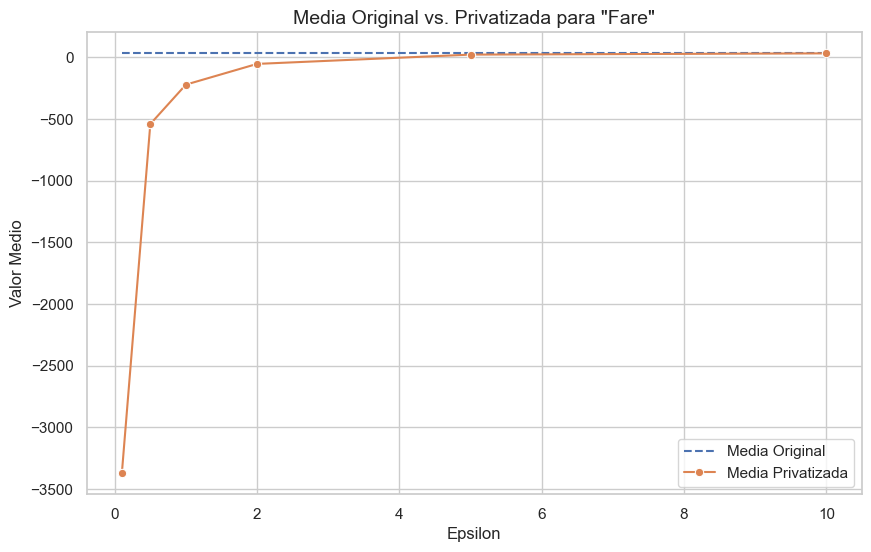

In [7]:
dp_tr.plot_mean_vs_privatized(method='piecewise')